In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set();
import numpy as np
from pylab import rcParams
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load Data

In [6]:
# Read csv with total net sales daily
df = pd.read_csv('../data/net_sales_total.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Read csv with daily weather
weather_df = pd.read_csv('../data/dark_sky_api.csv')
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df = weather_df.rename(columns={'time':'date'})
weather_df = weather_df.set_index('date')

# Merge both dataframes
df = df.merge(weather_df, on='date')

In [5]:
df = df[df['total']>50]

In [7]:
df = df.reset_index()
df['day_of_week'] = df['date'].dt.day_name()
df['week_of_year'] = df['date'].dt.weekofyear
df['month_name'] = df['date'].dt.month_name()
df['quarter'] = df['date'].dt.quarter

df = df.set_index('date')

### Daily EDA

Plotting daily sales for whole dataset

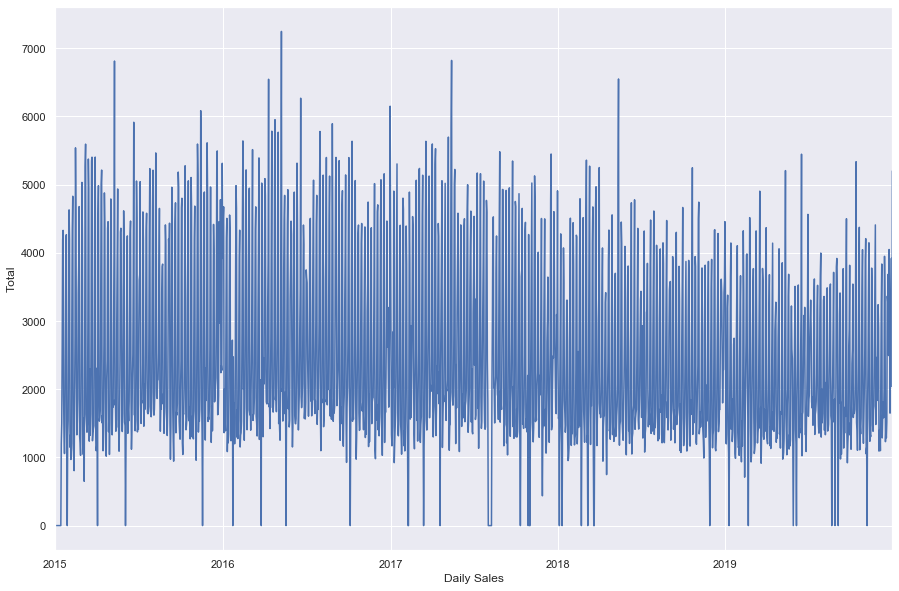

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
ax = df['total'].plot()
ax.set_xlabel('Daily Sales');
ax.set_ylabel('Total');

Plotting daily max temp for whole dataset

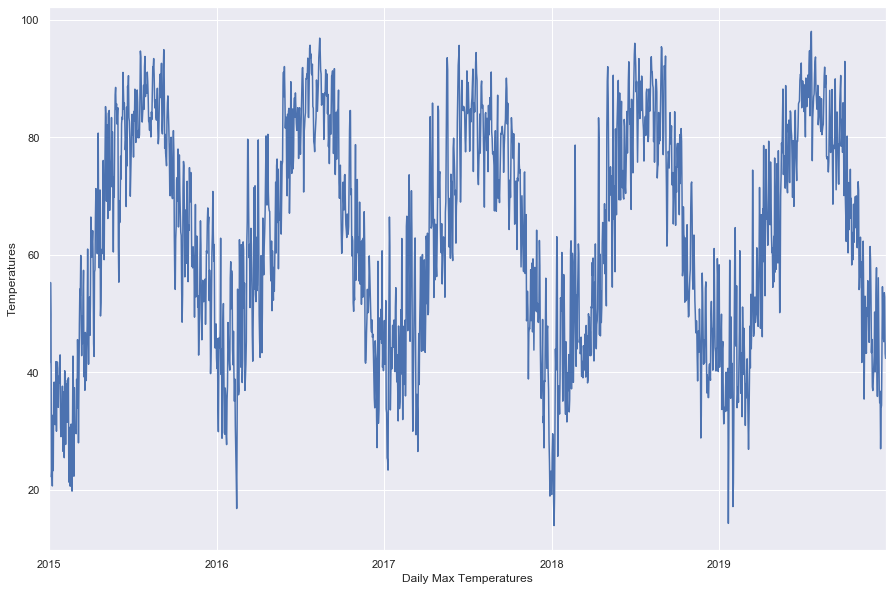

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
df['temperatureMax'].plot()
ax.set_xlabel('Daily Max Temperatures');
ax.set_ylabel('Temperatures');

Plotting Rolling Mean for 30 days

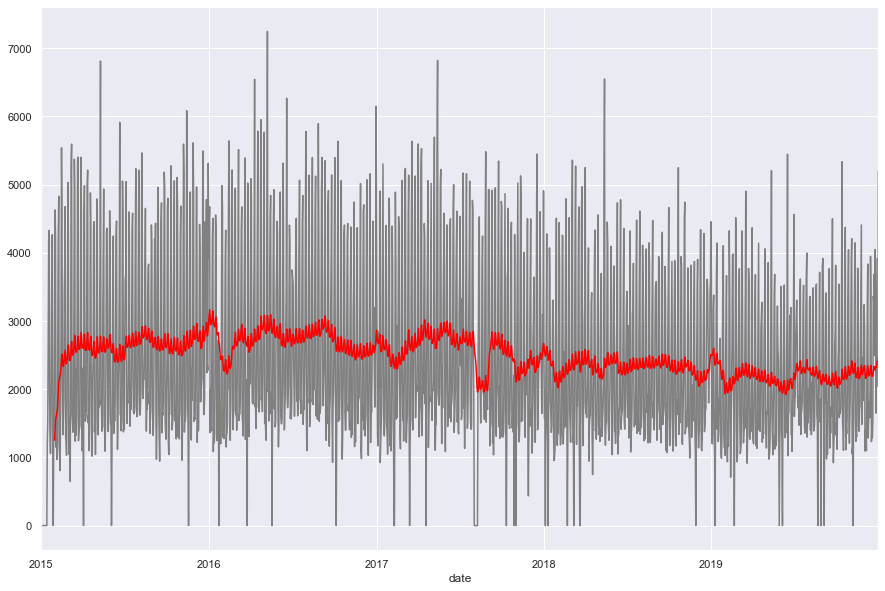

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
r = df.rolling(window = 30)
df['total'].plot(color = 'gray')
r.mean()['total'].plot(color = 'red');

In [11]:
total = df[['total']]

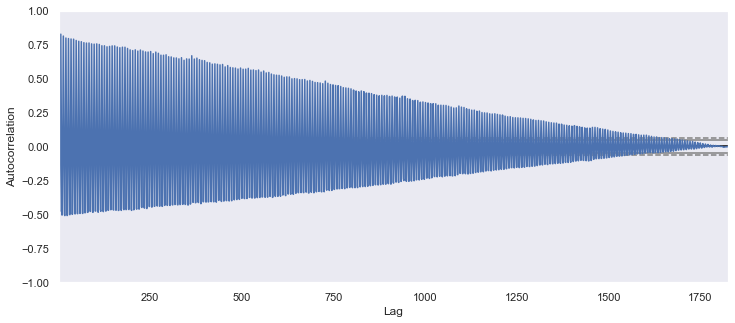

In [12]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(total);

In [13]:
temp_max = df[['temperatureMax']]

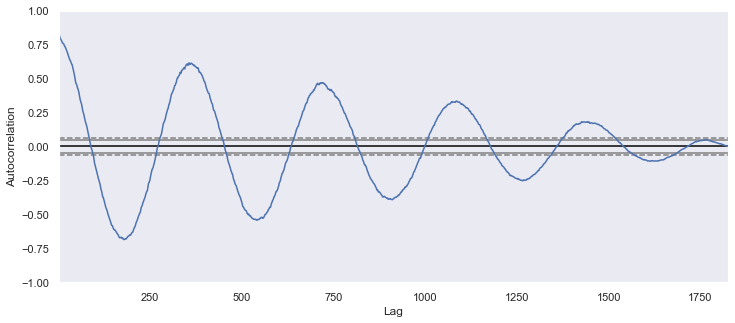

In [14]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(temp_max);

### Weekly EDA

In [15]:
total_weekly = df['total'].resample('W').mean()
weather_weekly = df['temperatureMax'].resample('W').mean()

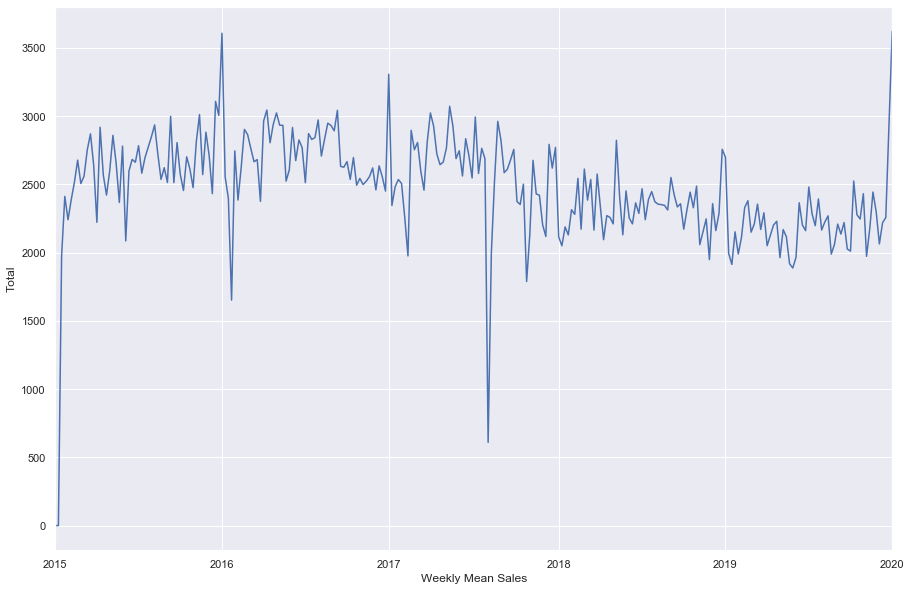

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
total_weekly.plot();
ax.set_xlabel('Weekly Mean Sales');
ax.set_ylabel('Total');

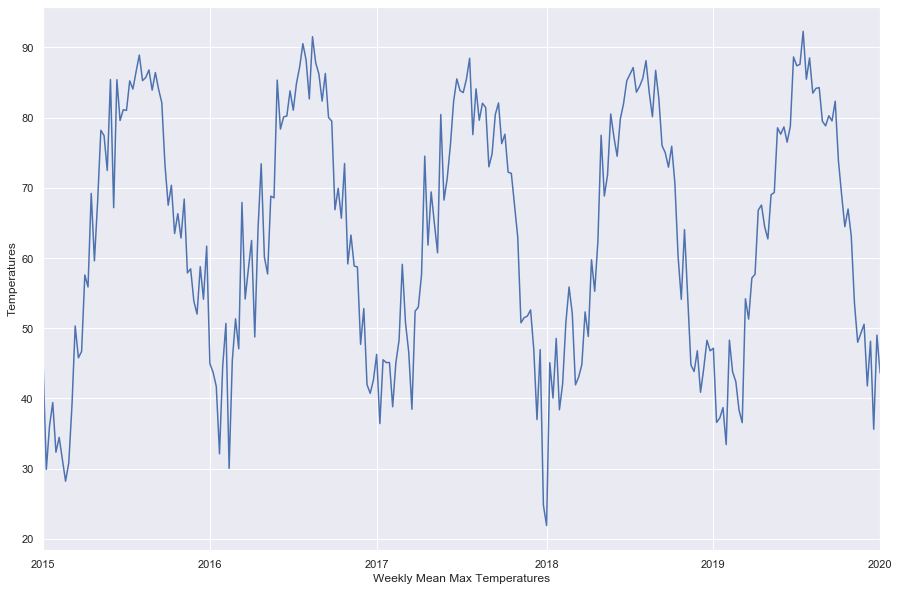

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
weather_weekly.plot();
ax.set_xlabel('Weekly Mean Max Temperatures');
ax.set_ylabel('Temperatures');

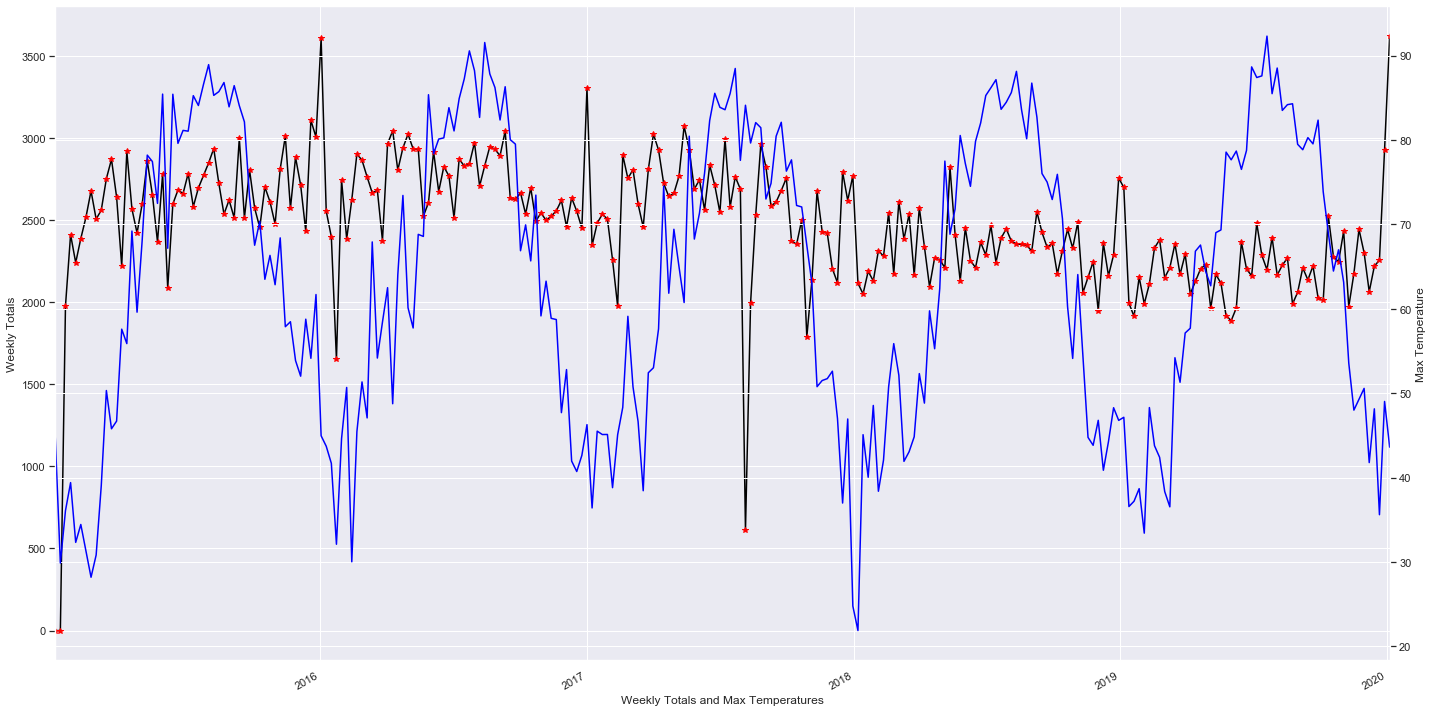

In [18]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_ylabel('Weekly Totals')
ax1.plot(total_weekly, color = 'black')
total_weekly.plot(style = '*', color = 'red')

ax2 = ax1.twinx()
ax2.set_ylabel('Max Temperature')
ax2.plot(weather_weekly, color = 'blue')

ax1.set_xlabel('Weekly Totals and Max Temperatures')
fig.tight_layout()
plt.show()

### Monthly EDA

In [19]:
total_monthly = df['total'].resample('MS').mean()
weather_monthly = df['temperatureMax'].resample('MS').mean()

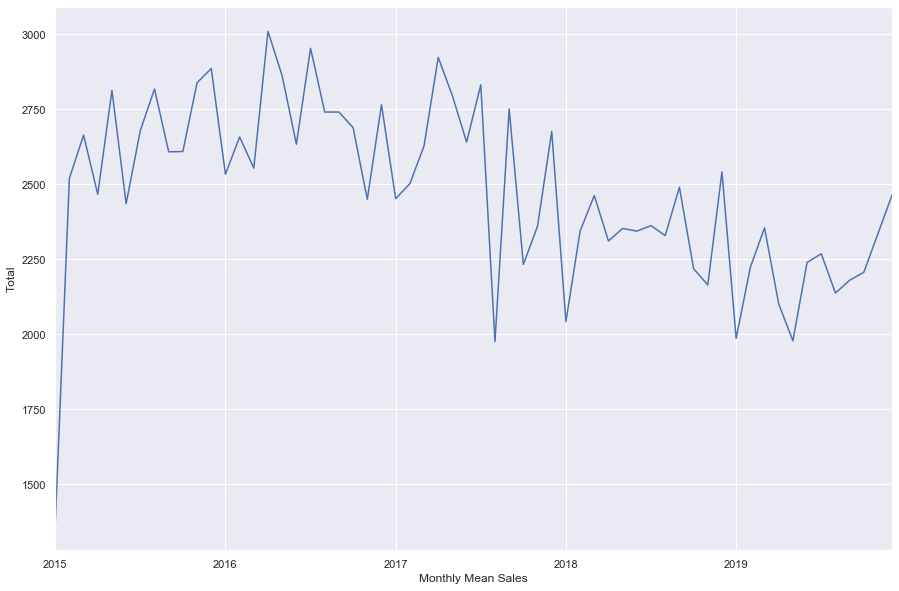

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
total_monthly.plot();
ax.set_xlabel('Monthly Mean Sales');
ax.set_ylabel('Total');

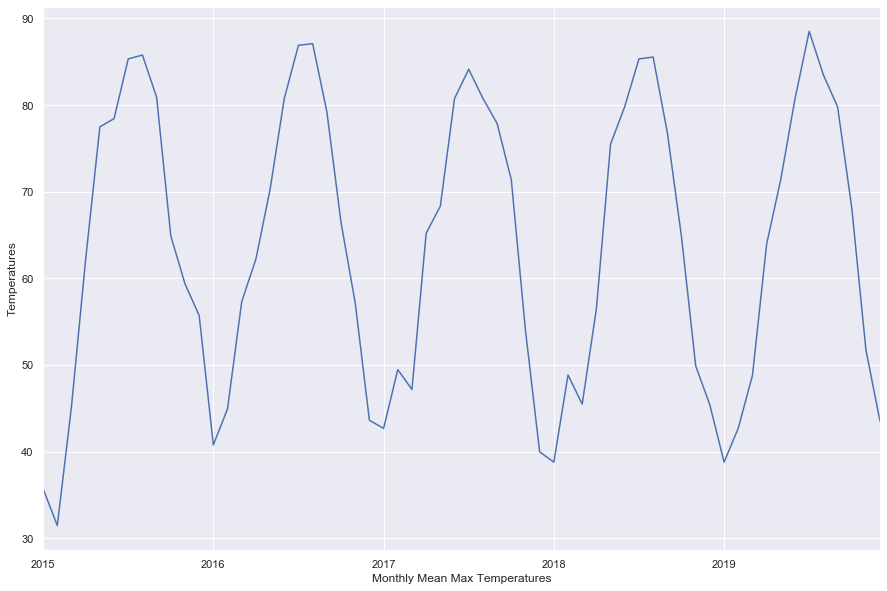

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
weather_monthly.plot();
ax.set_xlabel('Monthly Mean Max Temperatures');
ax.set_ylabel('Temperatures');

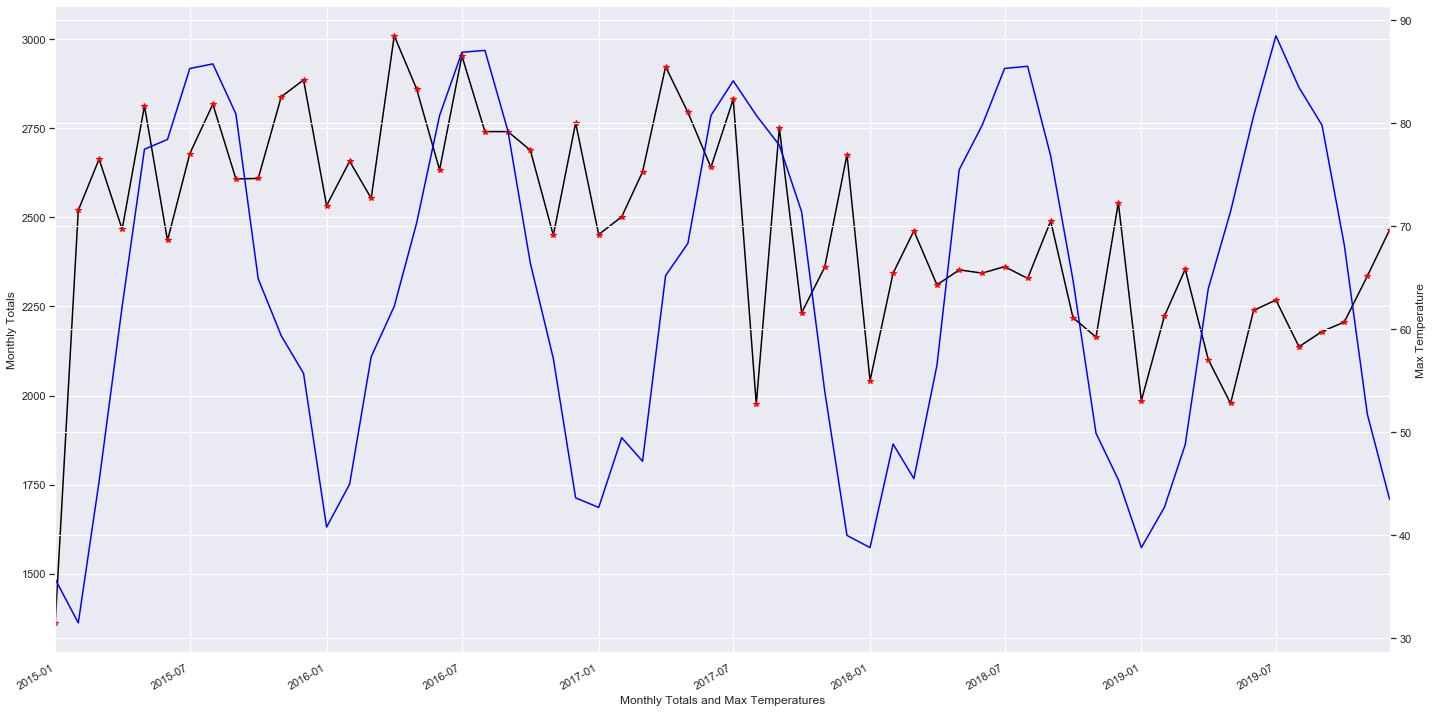

In [22]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_ylabel('Monthly Totals')
ax1.plot(total_monthly, color = 'black')
total_monthly.plot(style = '*', color = 'red')

ax2 = ax1.twinx()
ax2.set_ylabel('Max Temperature')
ax2.plot(weather_monthly, color = 'blue')

ax1.set_xlabel('Monthly Totals and Max Temperatures')
fig.tight_layout()
plt.show()

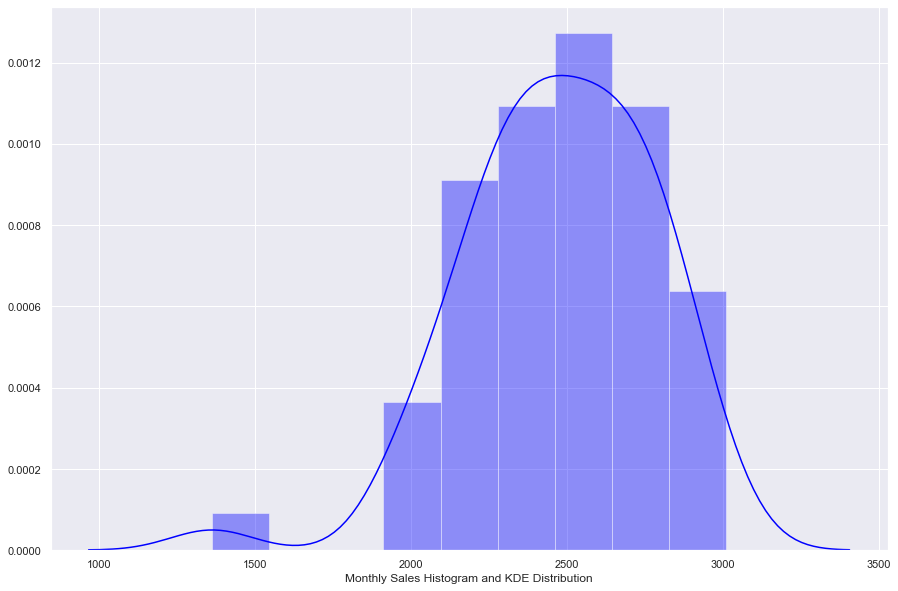

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(total_monthly, color='blue')
ax.set_xlabel('Monthly Sales Histogram and KDE Distribution');

### Yearly EDA

In [25]:
total_yearly = df['total'].resample('YS').mean()
weather_yearly = df['temperatureMax'].resample('YS').mean()

total_year_groups = total_monthly.groupby(pd.Grouper(freq ='A'))
weather_year_groups = weather_monthly.groupby(pd.Grouper(freq = 'A'))

In [26]:
pd.DataFrame(total_year_groups)

,0,1
0,2015-12-31,date 2015-01-01 1361.620968 2015-02-01 2...
1,2016-12-31,date 2016-01-01 2533.112903 2016-02-01 2...
2,2017-12-31,date 2017-01-01 2451.737097 2017-02-01 2...
3,2018-12-31,date 2018-01-01 2041.653226 2018-02-01 2...
4,2019-12-31,date 2019-01-01 1985.806452 2019-02-01 2...


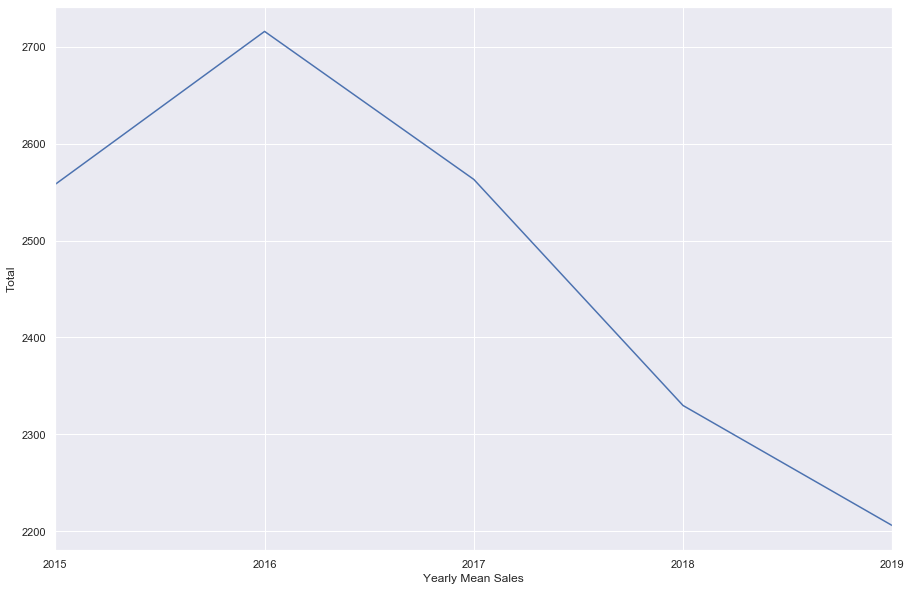

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
total_yearly.plot();
ax.set_xlabel('Yearly Mean Sales');
ax.set_ylabel('Total');

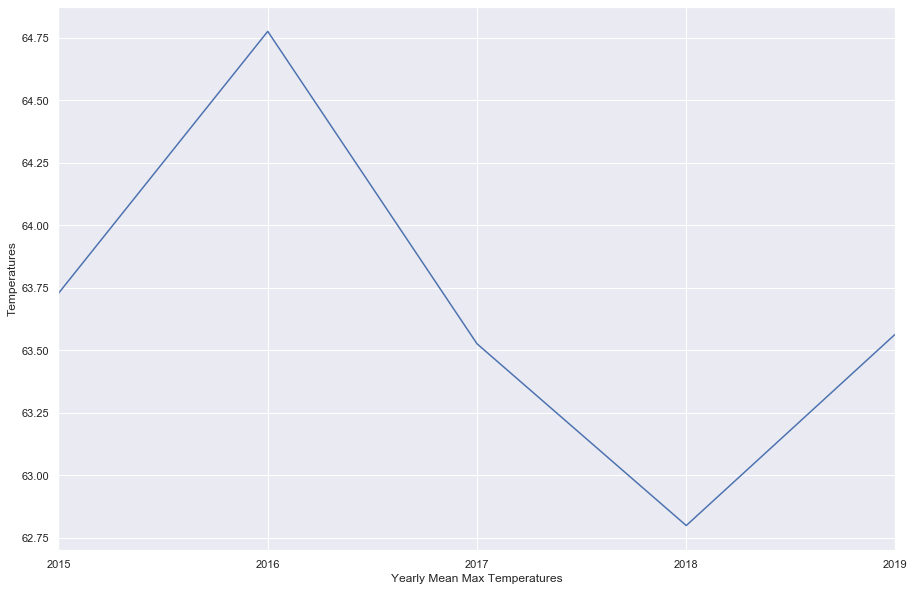

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
weather_yearly.plot();
ax.set_xlabel('Yearly Mean Max Temperatures');
ax.set_ylabel('Temperatures');

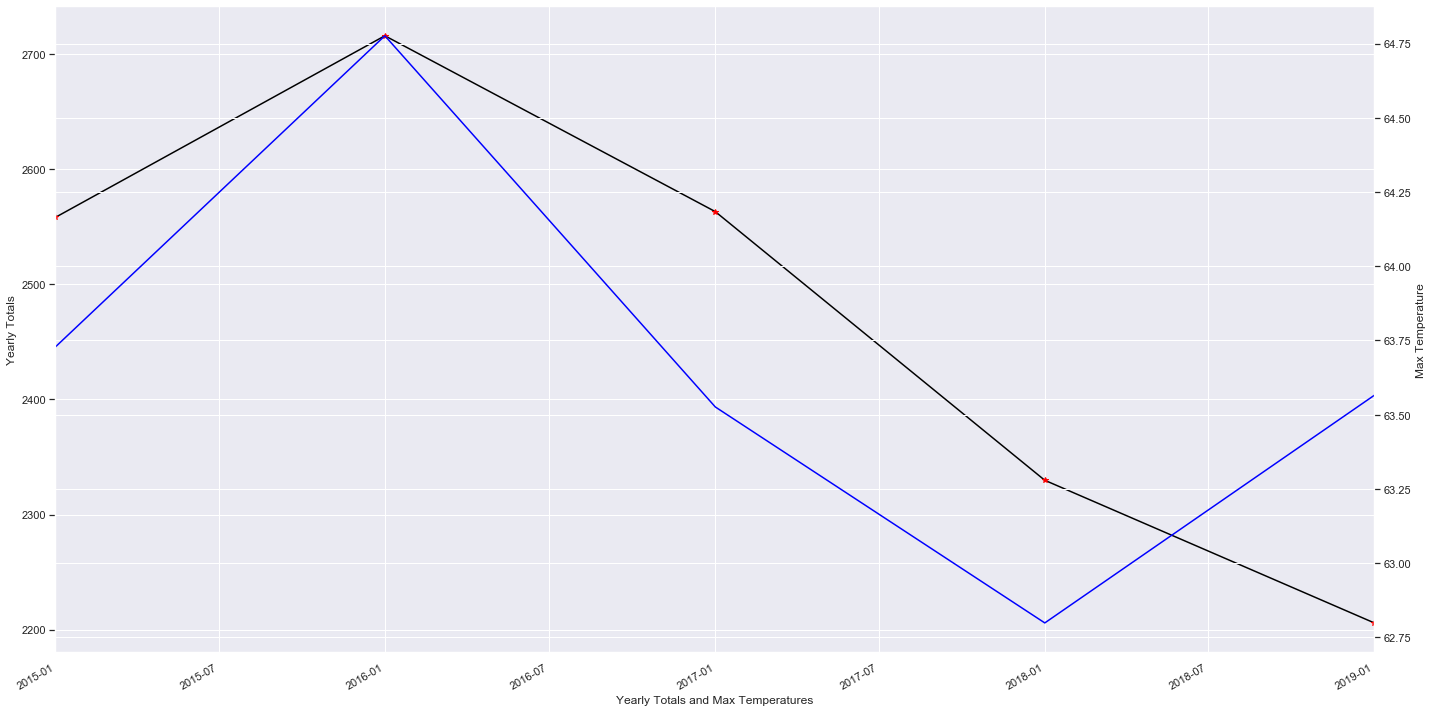

In [29]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_ylabel('Yearly Totals')
ax1.plot(total_yearly, color = 'black')
total_yearly.plot(style = '*', color = 'red')

ax2 = ax1.twinx()
ax2.set_ylabel('Max Temperature')
ax2.plot(weather_yearly, color = 'blue')

ax1.set_xlabel('Yearly Totals and Max Temperatures')
fig.tight_layout()
plt.show()

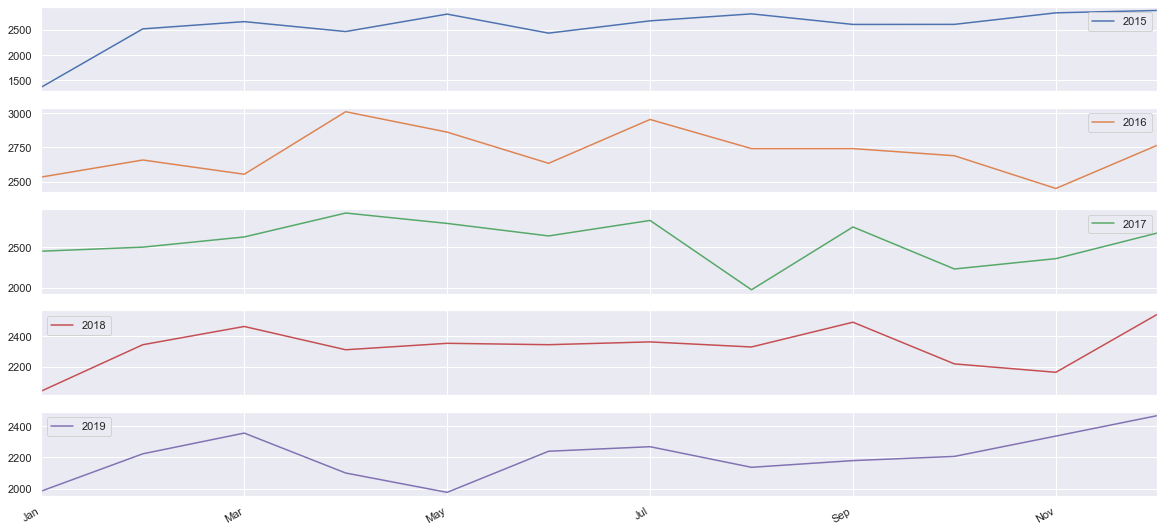

In [30]:
# Create a new DataFrame and store yearly values in columns 
total_annual = pd.DataFrame()
# weather_annual = pd.DataFrame()

for yr, group in total_year_groups:
#     print(f'year: {yr} || yr.year: {yr.year} || group: {group}')
    total_annual[yr.year] = group.values.ravel()
    
# for yr, group in weather_year_groups:
#     weather_annual[yr.year] = group.values.ravel()
    
total_annual = total_annual.rename({0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 
                                     4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 
                                     8:'Sep', 9:'Oct', 10:'Nov', 11:'Dec'})
    
# Plot the yearly groups as subplots
total_annual.plot(figsize = (20,10), subplots=True, legend=True);
# weather_annual.plot(figsize = (20,10), subplots=True, legend=True);

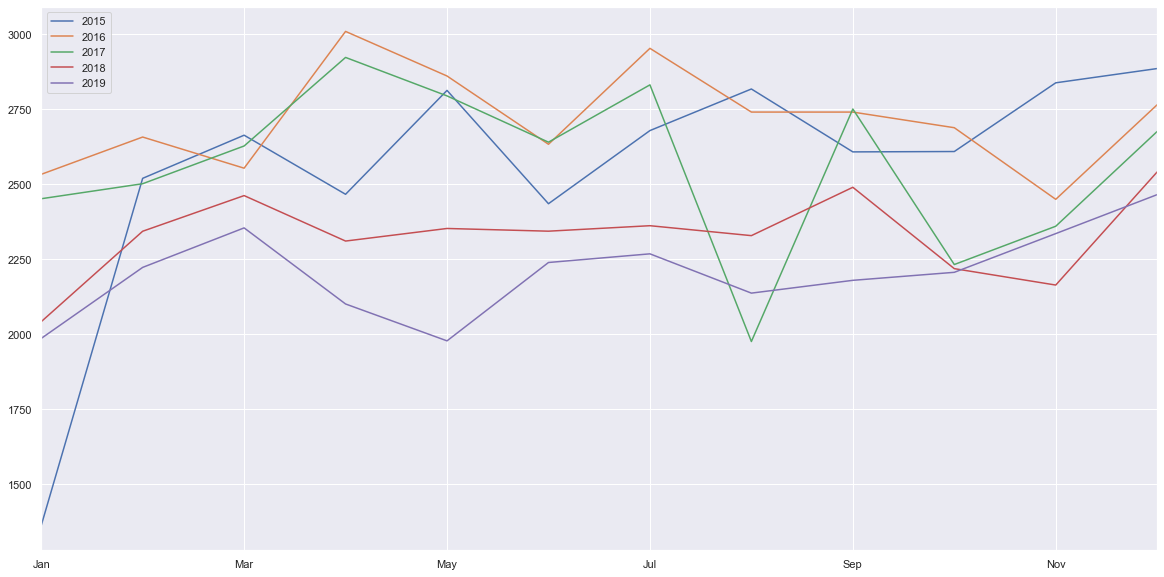

In [31]:
total_annual.plot(figsize = (20,10), subplots=False, legend=True);

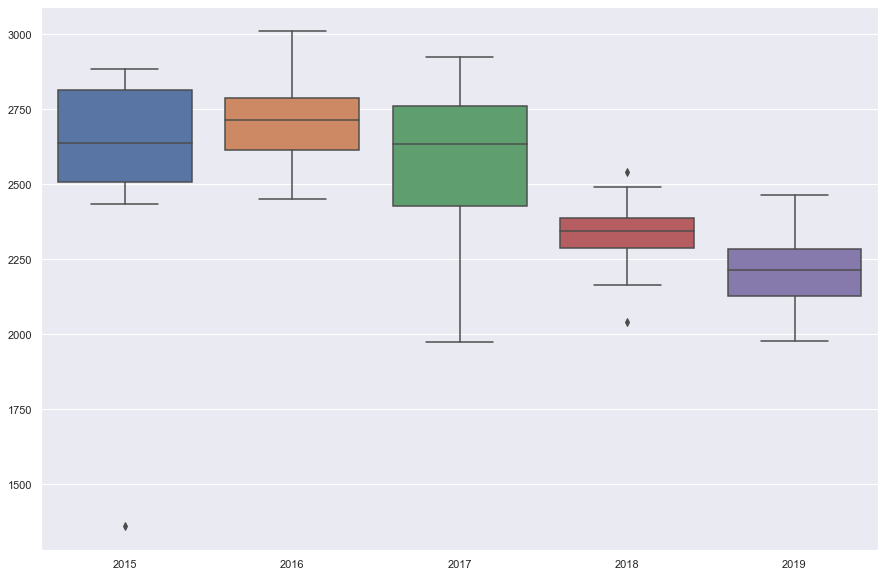

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=total_annual)

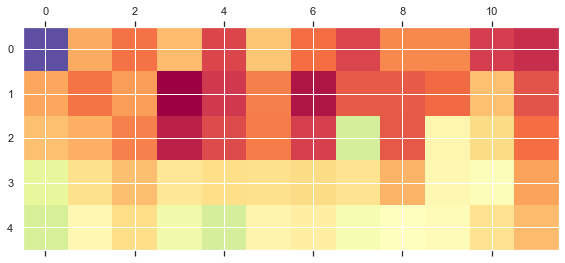

In [33]:
year_matrix = total_annual.T
plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r);

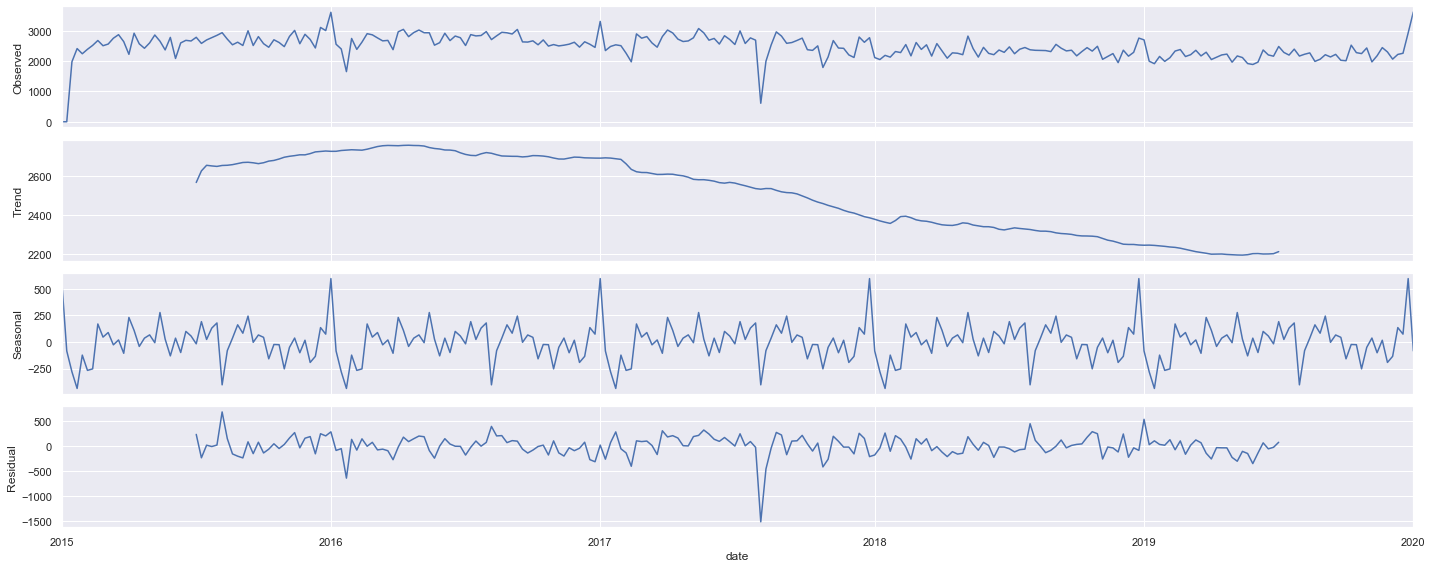

In [34]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(total_weekly, model='additive')
fig = decomposition.plot()
plt.show()

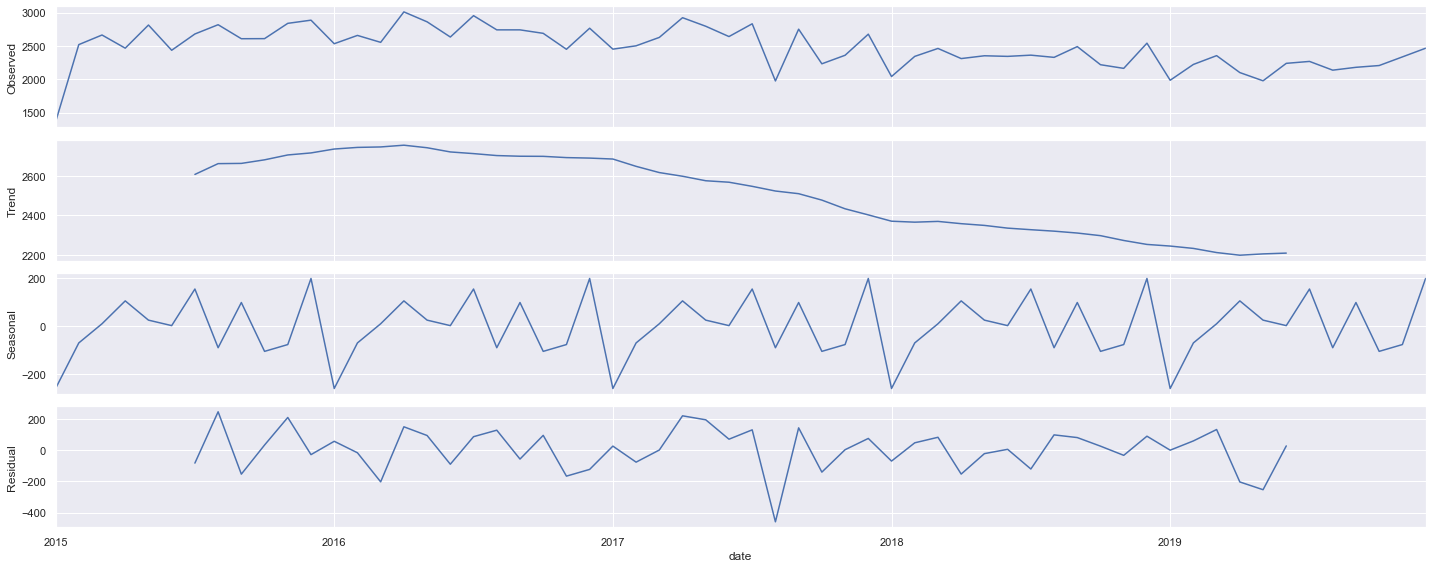

In [35]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(total_monthly, model='additive')
fig = decomposition.plot()
plt.show()

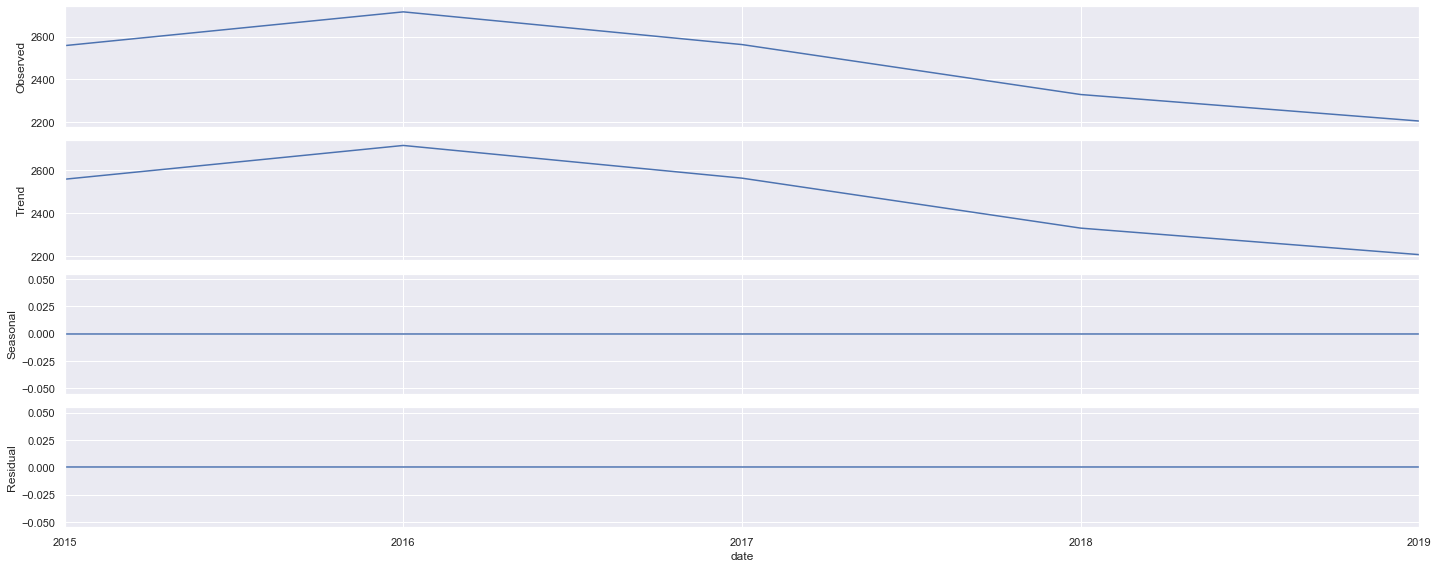

In [36]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(total_yearly, model='additive')
fig = decomposition.plot()
plt.show()

In [37]:
total_monthly_reset_index = pd.DataFrame(total_monthly).reset_index()

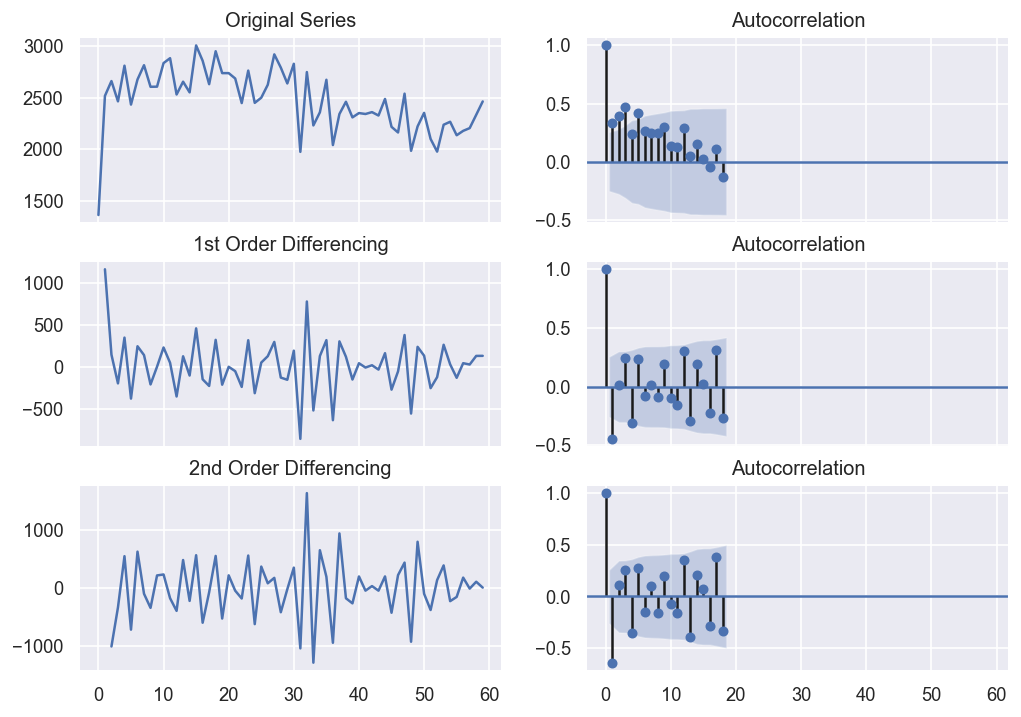

In [38]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(total_monthly_reset_index.total); axes[0, 0].set_title('Original Series')
plot_acf(total_monthly_reset_index.total, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(total_monthly_reset_index.total.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(total_monthly_reset_index.total.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(total_monthly_reset_index.total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(total_monthly_reset_index.total.diff().diff().dropna(), ax=axes[2, 1])

plt.show()
